# **implementation**
https://scikit-learn.org/stable/modules/model_evaluation.html

## **pip install package**


In [ ]:
pip install besuto=='0.1.0a1'

In [1]:
!pip install tensorflow;
!pip install mtcnn;
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications

     |████████████████████████████████| 2.3MB 31.2MB/s 
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-3in9vim8
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-3in9vim8
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp37-none-any.whl size=8312 sha256=d520d94142ba1b428cfef048c4a6f2e902839ef5805facd6a2185b6f49b7c794
  Stored in directory: /tmp/pip-ephem-wheel-cache-pw3fp4ot/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface
     |████████████████████████████████| 51kB 6.9MB/s 


## **Check Package Version**

In [2]:
import tensorflow as tf
import logging
print('tenserflow version : ',tf.__version__)
 
# confirm mtcnn was installed correctly
import mtcnn
# print version
print('mtcnn version : ',mtcnn.__version__)
 
# check version of keras_vggface
import keras_vggface
# print version
print('VggFace2 version : ',keras_vggface.__version__)
logging.getLogger('tensorflow').setLevel(logging.FATAL)

tenserflow version :  2.4.1
mtcnn version :  0.1.0
VggFace2 version :  0.6


##  **Import New package**

this is libaries that used in this project




In [3]:
#for neural network complement
from keras.models import Sequential,Model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
import tensorflow as tf
#import library for Data Cleaning
from mtcnn import MTCNN
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import os 
from PIL import Image
from timeit import default_timer as timer
print('import successfully...')

import successfully...


# **Data preparing**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Data Loading**

use this section to import all images dataset and data label into colab project

*   mount path
*   load dataset Path List
*   import image dataset
*   check if it loaded probably




**load images path  and mount path**

## **Build data Augment Function**

In [5]:
def Augment(array,generation):
  #lightlevel augmentation
  result = []
  token = np.expand_dims(array,0)
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,brightness_range=[0.2,1.0],rotation_range = 37)
  generate = datagen.flow(token,batch_size=1)
  for i in range(generation**3):
    batch = generate.next()
    image = batch[0].astype('uint8')
    result.append(np.asarray(image))
  return np.asarray(result)

In [6]:
# function for face detection with mtcnn
def extract_face(filename,size=(256,256)):
  image = Image.open(filename)
  image = image.convert('RGB')
  array = np.asarray(image)
  detector = MTCNN()
  face_detected = detector.detect_faces(array)
  if face_detected ==[]:
    return []
  x1, y1, width, height = face_detected[0]['box']
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1 + width, y1 + height
  face = array[y1:y2, x1:x2]
  face = Image.fromarray(face)
  face = face.resize(size)
  face = np.asarray(face)
  return face
 
def load_dataset_multifolder(directory ='',aug=True):
  X,y = [], []
  # loop every folder
  for folder in sorted(os.listdir(directory)):
    path = directory + folder+'/'
    if not os.path.isdir(path):
      continue
    faces = []
    for filename in os.listdir(path):
      face = extract_face(path + filename)
      if face != []:
        faces.append(face)
      else:
        pass
    faces = np.asarray(faces)
    augment = []
    if aug == True:
      for i in faces:
        augment.extend(Augment(i,generation=5))
    else:
      augment.extend(faces)
    labels = [folder for i in range(len(augment))]
    X.extend(augment)
    y.extend(labels)
  return np.asarray(X), np.asarray(y)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import GradientBoostingClassifier

def create_model(model_type):
    if model_type == "knn":
        return KNeighborsClassifier(n_neighbors=5) 
    elif model_type == "dc": # decision tree
        return DecisionTreeClassifier(criterion="entropy", \
                                      max_depth = 50, \
                                      min_samples_split = 200)
    elif model_type == "nb": # Naive Bayes
        return ComplementNB()
    elif model_type == "logit":
        return  LogisticRegression(C = 2.0, \
                                   max_iter = 1000, \
                                   multi_class = "ovr", \
                                   solver = "liblinear")
    elif model_type == "nn": # Neural Network
        return MLPClassifier(hidden_layer_sizes=(400, 200))
    elif model_type == "svm":
        return LinearSVC(random_state=0, dual=False, tol=1e-5, max_iter =10000)
    elif model_type == "adb":
        return AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion="entropy", \
                                                    max_depth = 50, \
                                                    min_samples_split = 200), \
                                                    n_estimators = 100)
    elif model_type == 'gdb':
        return GradientBoostingClassifier(random_state=0)
    else:
        raise ValueError(model_type)

## **load image and use Augmentation**

In [8]:
%%capture
image_path = "/content/drive/My Drive/Colab Notebooks/facelink/imagenet dataset/case3/train/"
X_train, y_train = load_dataset_multifolder(image_path)

test_path = '/content/drive/My Drive/Colab Notebooks/facelink/imagenet dataset/case3/test/'
testset, label = load_dataset_multifolder(test_path,aug=False)

# **run the pipeline**

In [9]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
from keras_vggface.vggface import VGGFace

In [10]:
def run_pipeline(X_train, y_train, X_test, y_test):
  tf.keras.backend.clear_session()
  tf.random.set_seed(51)
  feature_extractor = VGGFace(model='resnet50',weights ='vggface',include_top =False,input_shape = X_train[0].shape)
  #load this to local and load_weightinput_shape
  for layer in feature_extractor.layers:
      layer.trainable = False
    
  # Full list is ["knn", "dc", "nb", "logit", "nn", "svm", "adb", "gdb"]
  model_types = ["knn", "nb", "logit", "nn", "svm"]  

  num_of_layer = 48  
  test_acc_comparison = dict()

  model_names = []
  train_f1_scores = []
  training_time = []
  test_f1_scores = []
  testing_time = []
  biases = []
  variences = []


  for model in range(int(num_of_layer /2),num_of_layer +1):
    layer_name ='activation_{}'.format(model)
    feature_extractor.get_layer(layer_name)
    feature = tf.keras.layers.Flatten()(feature_extractor.predict(X_train))
    test_feature = tf.keras.layers.Flatten()(feature_extractor.predict(X_test))
    for model_type in model_types:
      # 5 Train a model
      model = create_model(model_type)
      print('---------- training {} {} model ----------'.format(model_type,layer_name))
      start = timer()
      model.fit(feature,y_train)
      end = timer()
      traintime = end - start

      # 6. Prediction
      train_y_pred = model.predict(feature)
      test_y_pred = model.predict(test_feature)

      # 7. Evaluation
      train_acc = model.score(feature,y_train)
      start = timer()
      test_acc = model.score(test_feature,y_test)
      end = timer()
      testtime = end - start
      test_acc_comparison[model_type+'_'+layer_name] = test_acc
          
      # find overfitting & underfitting
      bias = 1 - train_acc # train_err
      test_err = 1 - test_acc
      variance = test_err - bias

      model_names.append(model_type+'_'+layer_name)

          
      print(f"Training Acc: {train_acc}")
      print(f"Test Acc: {test_acc}")
      print(f"Training time: {traintime}")
      print(f"Test time: {testtime}")
      print(f"Bias: {bias}")
      print(f"Varaince: {variance} \n")

      train_f1_scores.append(train_acc)
      training_time.append(traintime)
      test_f1_scores.append(test_acc)
      testing_time.append(testtime)
      biases.append(bias)
      variences.append(variance)  

          
      # Print confusion matrix
      print("Confusion Matrix")
      confusion_matrix = pd.crosstab(y_test, test_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
      print(confusion_matrix)

      print("\nReport")
      print(metrics.classification_report(y_test, test_y_pred))
          
      print("\n")
              
      plot_confusion_matrix(model, test_feature, y_test)
      plt.show()
  report = {
      'f1-score (trainset)': train_f1_scores,
      'f1-score (testset)': test_f1_scores,
      'training time': training_time,
      'evaluate time': testing_time, 
      'bias': biases, 
      'varience': variences
  }
  table = pd.DataFrame(report)
  return table.set_index(pd.Index(model_names))

In [11]:
report = run_pipeline(X_train, y_train, testset, label)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
#display(test_acc_comparison)

In [13]:
report.to_csv('/content/drive/MyDrive/Colab Notebooks/facelink/model output/training_report1.csv')

# try to use model from testset

In [ ]:
#'nn_activation_41'
tf.keras.backend.clear_session()
tf.random.set_seed(51)
feature_extractor = VGGFace(model='resnet50',weights ='vggface',include_top =False,input_shape = X_train[0].shape)
#load this to local and load_weightinput_shape
for layer in feature_extractor.layers:
    layer.trainable = False
layer_name ='activation_{}'.format(41)
feature_extractor.get_layer(layer_name)
feature = tf.keras.layers.Flatten()(feature_extractor.predict(X_train))
model = MLPClassifier(hidden_layer_sizes=(400, 200))
model.fit(feature,y_train)
filename = '/content/model.sav'
pickle.dump(model, open(filename, 'wb'))

94699520/94694792 [==============================] - 4s 0us/step


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(400, 200), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/facelink/imagenet dataset/case3/test/modi/modi10.jpg'
testimg = extract_face(filename)

NameError: ignored

prediction = ['modi']


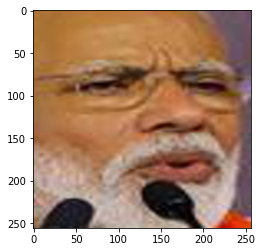

In [ ]:
plt.imshow(testimg)
feature = tf.keras.layers.Flatten()(feature_extractor.predict(np.expand_dims(testimg,0)))
pred = model.predict(feature)
print('prediction = {}'.format(pred))

# data augment time test

In [ ]:
from besuto.images.augment import imagedata
from timeit import default_timer as timer

In [ ]:
times = []
image_path = "/content/drive/My Drive/Colab Notebooks/facelink/imagenet dataset/case3/train/"
for i in range(1,10):
  start = timer()
  data = imagedata(augment = True,generation=i)
  X,y = data.load_faces_dataset(image_path)
  end = timer()
  times.append({'generation':i,'time':end - start,'num':X.shape[0]})


In [ ]:
display(times)

[{'generation': 1, 'num': 25, 'time': 14.576287822999802},
 {'generation': 2, 'num': 200, 'time': 17.447069791000104},
 {'generation': 3, 'num': 675, 'time': 23.89991469000006},
 {'generation': 4, 'num': 1600, 'time': 40.472539299000346},
 {'generation': 5, 'num': 3125, 'time': 65.93300193200002},
 {'generation': 6, 'num': 5400, 'time': 99.88288638199992},
 {'generation': 7, 'num': 8575, 'time': 150.44750946899967},
 {'generation': 8, 'num': 12800, 'time': 216.8316744849999},
 {'generation': 9, 'num': 18225, 'time': 301.90428218199986}]

In [ ]:
!pip install nbconvert

In [ ]:
!jupyter nbconvert --to html SVM_asclassify.ipynb

[NbConvertApp] Converting notebook SVM_asclassify.ipynb to html
[NbConvertApp] Writing 2706421 bytes to SVM_asclassify.html
